In [157]:
import torch;
import matplotlib.pyplot as plt;
import matplotlib_inline.backend_inline as mibi;
mibi.set_matplotlib_formats("svg","pdf");
import torchvision;
import torchvision.transforms as transforms;
import os;
from torch.utils.data import DataLoader;
from lightly.data import LightlyDataset;
import torch.nn as nn;
from tqdm import tqdm;
import torch.nn.functional as F;

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [158]:
file_size = 512

In [159]:
transform = transforms.Compose([
    transforms.Resize((file_size, file_size)),  # Resize images to 64x64
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

data_path = "../../python/data/CUFS/gg/";
celeba_datasets = LightlyDataset(input_dir=os.path.join(data_path,"train"),transform=transform);
data_loader = DataLoader(celeba_datasets,batch_size=4);

In [160]:
x,label,fnames = next(iter(data_loader));
print(x.shape)

torch.Size([4, 3, 512, 512])


torch.Size([3, 1030, 1030])


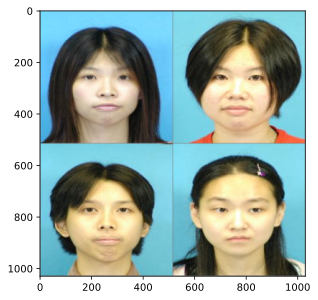

In [161]:
grid = torchvision.utils.make_grid(x,nrow=2);
print(grid.shape)
grid = (grid*0.5 + 0.5).permute(1,2,0)

plt.imshow(grid.numpy());

In [162]:
### Check pretrained

In [163]:
state = torch.load("./weights/model_ckpt_steps_300000.ckpt");

In [164]:
weight = state["state_dict"]["model"];
print(type(weight))

<class 'collections.OrderedDict'>


In [165]:
for k in weight:
    pass;
    #print(k,weight[k].shape)

In [166]:
from models.diffusion import GaussianDiffusion;
from models.diffsr_modules import Unet,RRDBNet;

unet = Unet(dim=64,out_dim=3,dim_mults=(1,2,2,4));
rrdb = RRDBNet(in_nc=3,out_nc=3,nf=32,nb =8,gc = 16);

model = GaussianDiffusion(denoise_fn=unet,rrdb_net=rrdb,timesteps=100);

dim 64


In [167]:
device = "cuda"
model.load_state_dict(weight);
model = model.to(device);

In [168]:
import torchvision.transforms.functional as f;
test_hr = x[0]

test_lr= f.to_tensor(f.gaussian_blur(f.resize(img = f.to_pil_image((test_hr+1)/2),size=(file_size//8,file_size//8)),kernel_size=(3,3),sigma=2));

In [169]:
test_lr=test_lr.unsqueeze(0);
test_hr = test_hr.unsqueeze(0);

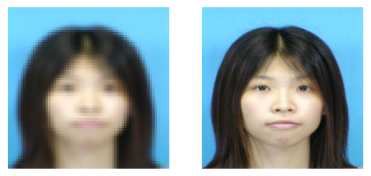

In [170]:
plt.subplot(1,2,1);
plt.imshow(test_lr.squeeze().permute(1,2,0));
plt.axis("off");
plt.subplot(1,2,2);
plt.imshow(test_hr.squeeze().permute(1,2,0)*.5 + .5);
plt.axis("off");

sampling loop time step: 100%|██████████| 100/100 [00:03<00:00, 28.42it/s]


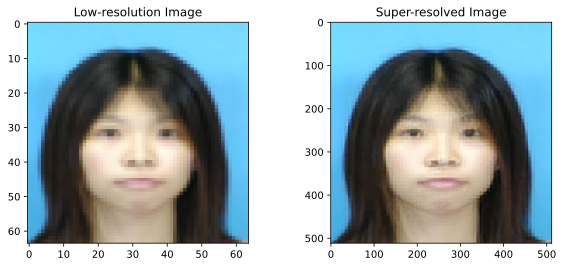

In [183]:
# Prepare the low-resolution image by resizing and adding gaussian blur
low_res_transform = transforms.Compose([
    transforms.Resize((file_size//8, file_size//8)),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the low-res image and transform it
lr_image_pil = f.to_pil_image((test_hr.squeeze()+1)/2)  # Convert tensor to PIL image
lr_image_tensor = low_res_transform(lr_image_pil).unsqueeze(0)  # Add batch dimension

# Move the model and images to the correct device
lr_image_tensor = lr_image_tensor.to(device)
model.eval()  # Set the model to evaluation mode
upsampled_lr_image = F.interpolate(lr_image_tensor, size=(file_size, file_size), mode='nearest')
# Sample a high-resolution image from the model
with torch.no_grad():
    sr_image, _ = model.sample(lr_image_tensor, upsampled_lr_image, (1, 3, file_size, file_size))

# Convert the tensor to a displayable image
sr_image = sr_image.squeeze(0).cpu()  # Remove batch dimension and move to cpu
sr_image = (sr_image * 0.5 + 0.5).clamp(0, 1)  # Denormalize and clamp for valid image values
sr_image_pil = transforms.ToPILImage()((sr_image))   # Convert to PIL image for display

# Display the images
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(lr_image_tensor.cpu().squeeze().permute(1, 2, 0)*0.5 + .5)
plt.title('Low-resolution Image')


plt.subplot(1, 2, 2)
plt.imshow(sr_image_pil)
plt.title('Super-resolved Image')
plt.show()

In [ ]:
def expand_axis_like(a, b):
    """ Expands axes (at the end) of b to have the same number of axis as a.

    Args:
        a (Tensor): A reference tensor.
        b (Tensor): A target tensor to be expanded.

    Returns:
        Expanded version of b.

    """
    assert len(a.shape) >= len(b.shape), f"The number of axis in a must greater than b. Shape a: {a.shape}, Shape b: {b.shape}"
    n_unsqueeze = len(a.shape) - len(b.shape)
    b = b[(..., ) + (None, ) * n_unsqueeze] # unsqueeze such that it has the same size for broadcasting.
    return b

class NoiseScheduler:
    def __init__(self, T, mode="linear"):
        """ Noise Scheduler Abstract Class

        Args:
            T (int): A maximum number of diffusion timestep.

        """
        self.T = T
        self.mode = mode
        self.init_alpha_beta()

    def init_alpha_beta(self):
        """ Initialize alpha and beta parameters based on the scheduler. """
        t = (torch.linspace(start = 1,end=self.T,steps=self.T)-1)/(self.T-1);
        if self.mode == "linear":
            # TODO 1: initialize parameters for linear scheduler
            self.beta = 1e-4*(1-t) + 0.02*t;
            self.alpha = 1.0-self.beta;
            self.alpha_cumprod = torch.cumprod(self.alpha,dim = -1);
            self.alpha_cumprod_prev = torch.roll(self.alpha_cumprod,shifts=1);
            self.alpha_cumprod_prev[0] = 1.0;
        elif self.mode == "cosine":
            # TODO 2: initialize parameters for cosine scheduler
            ft = torch.cos(((t + 0.008)/(1+0.008)*(torch.pi/2)))**2;
            self.alpha_cumprod = ft/ft[0]
            self.alpha_cumprod_prev = torch.roll(self.alpha_cumprod,shifts=1);
            self.alpha_cumprod_prev[0] = 1;
            self.alpha = self.alpha_cumprod/(self.alpha_cumprod_prev)
            self.beta = torch.min(1-self.alpha,torch.tensor(0.999));
        else:
            raise NotImplementedError

    def _mean(self, x_0, t):
        """ Mean of p(x_t | x_0, t)

        Args:
            x_0 (Tensor): Clean images (Shape: (B, C, H, W))
            t (Tensor): Diffusion time-step (Shape: (B))

        Returns:
            Mean of p(x_t | x_0, t) (Shape: (B, C, H, W))

        """
        # TODO 3: calculate mean of p(x_t | x_0, t)
        alpha_cumprod_t = expand_axis_like(x_0,self.alpha_cumprod[t]);
        x_mean = (alpha_cumprod_t).sqrt()* x_0;
        return x_mean;

    def _std(self, t):
        """ Standard deviation of p(x_t | x_0, t)

        Args:
            t (Tensor): Diffusion time-step (Shape: (B))

        Returns:
            Standard deviation of p(x_t | x_0, t) (Shape: (B))

        """
        # TODO 4: calculate standard deviation of p(x_t| x_0, t)
        std = torch.sqrt(1-self.alpha_cumprod[t]);
        return std

    def marginal_prob(self, x_0, t):
        """ Marginal probability p(x_t | x_0, t)"""
        return self._mean(x_0, t), self._std(t)

    def sample_marginal_prob(self, x_0, t, noise=None):
        """ Sample x_t from p(x_t | x_0, t)

        Args:
            x_0 (Tensor): Clean images (Shape: (B, C, H, W))
            t (Tensor): Diffusion time-step (Shape: (B))
            noise (Tensor): A gaussian noise to be used in the reparameterization trick.
                            If it is None, noise is sample from standard normal. Default to None
        Returns:
            x_t (Shape: (B, C, H, W))

        """
        # TODO 5: sample $x_t \sim p(x_t | x_0, t)$ using a reparameterization trick in VAE
        # Note: You can use marginal_prob function to obtain the mean and std of p(x_t| x_0, t).
        #       If noise is provided, you must use it to sample x_t by setting z = noise. Otherwise, z is sampled from standard normal.
        mean, std = self.marginal_prob(
            x_0, t
        )  # Compute mean and std of the marginal prob.
        
        if(noise is None):
            noise = torch.randn_like(x_0)

        std = expand_axis_like(x_0,std);
        x_t = mean + std*noise;
        return x_t

    def prior_sampling(self, resolution, batch_size=1, num_channels=3):
        """ Sampling Gaussian noise

        Args:
            resolution (Tuple[int]): A tuple of integer indicates width and height of the image.
            batch_size (int, optional): A number of noise to be generated.
            num_channels (int, optional): A number of channels in the images.

        Returns:
            The sampling noises sample from Gaussian distribution.

        """
        return torch.randn(batch_size, num_channels, *resolution)

    def to(self, *args, **kwargs):
        """ Store the parameters on the given devices (eg. cpu, cuda) """
        self.alpha = self.alpha.to(*args, **kwargs)
        self.beta = self.beta.to(*args, **kwargs)
        self.alpha_cumprod = self.alpha_cumprod.to(*args, **kwargs)
        self.alpha_cumprod_prev = self.alpha_cumprod_prev.to(*args, **kwargs)
        return self

In [ ]:
up = nn.Upsample(scale_factor=8,mode="bicubic");

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


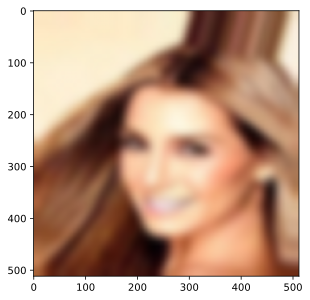

In [ ]:
r = up(test_lr);
plt.imshow(r.squeeze().permute(1,2,0));

In [ ]:
#Step 1
T = 12;
xl = test_lr;

#Step2
unet = model.denoise_fn;
rrdb = model.rrdb;

#step3
x_t = torch.randn_like(test_hr);

#step4
xl_up,xe = rrdb(xl,True);
#step5
#xl_up = up(test_lr);

#step 6
scheduler = NoiseScheduler(T, "linear");
for t in tqdm(range(T-1,-1,-1)):
    if t >= 1: 
        z = torch.randn_like(test_hr);
    else:
        z = torch.ones_like(test_hr);
        
    alpha_t = scheduler.alpha[t];
    alpha_bar = scheduler.alpha_cumprod[t];
    beta_t = scheduler.beta[t];
    alpha_bar_prev = scheduler.alpha_cumprod_prev[t];

    beta_hat_t = expand_axis_like(beta_t,(1-alpha_bar_prev)/(1-alpha_bar)) * beta_t;
    
    sigma = beta_hat_t.sqrt();
    epsilon = unet(x,torch.tensor(t,).repeat(x.shape[0]).long(),xe,xl_up);
    first_term = 1/(alpha_t.sqrt()) * (x_t - expand_axis_like(x_t,(1-alpha_t)/((1-alpha_bar).sqrt())*epsilon));
    second_term = sigma*z;
    
    x_t_prev = first_term + second_term;
    
sr_image = x_t_prev + xl_up;

100%|██████████| 12/12 [01:19<00:00,  6.63s/it]


In [ ]:
sr_image = sr_image.cuda()

In [ ]:
sr_image.shape

torch.Size([4, 3, 512, 512])

In [ ]:
img_lr_up = torch.rand(2,3,512,512).to(device);
img_hr = torch.rand(2,3,512,512).to(device);
img_lr = torch.rand(2,3,64,64).to(device);

In [ ]:
out = model(img_hr,img_lr,img_lr_up)

In [ ]:
type(out[2])

torch.Tensor

In [ ]:
out[1][0].shape

torch.Size([2, 3, 512, 512])

In [ ]:
out[1][1].shape

torch.Size([2, 3, 512, 512])

In [ ]:
out[1][2].shape

torch.Size([2, 3, 512, 512])